# Cargando series de tiempo en Python

In [69]:
# cargar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [70]:
# cargar archivo con datos en una tabla de Pandas (valores separados por comas)
#data = pd.read_csv('https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv')
data = pd.read_csv('AirPassengers.csv')
print(data.head())  # muestra los primeros renglones
print('\n Data Types:')
print(data.dtypes)

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object


In [71]:
# cargar datos, interpretando la columna "Month" como fechas y usándolas como índice
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
#data = pd.read_csv('https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv',
#                   parse_dates=['Month'], index_col='Month',date_parser=dateparse)
data = pd.read_csv('AirPassengers.csv',
                   parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print(data.head())

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


In [72]:
# muestra el índice
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [73]:
# convierte a Series (tipo de datos de Pandas para manejar series)
ts = data['#Passengers']
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

In [6]:
# datos hasta (incluyendo) mayo de 1949
ts[:'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [7]:
# datos del año 1949 (se pueden omitir las últimas componentes de una fecha)
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

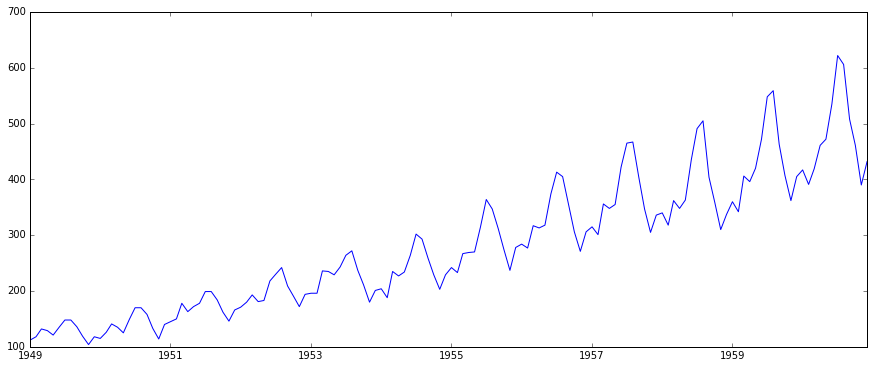

In [8]:
# graficando
plt.plot(ts)
# se puede observar:
#  tendencia creciente
#  estacionalidad

# Estacionariedad
### Prueba de Dickey-Fuller
Es estacionaria si
* Tanto media como desviación estándar son constantes, ó
* Estadística de la prueba de Dickey-Fullerson es menor que sus valores críticos

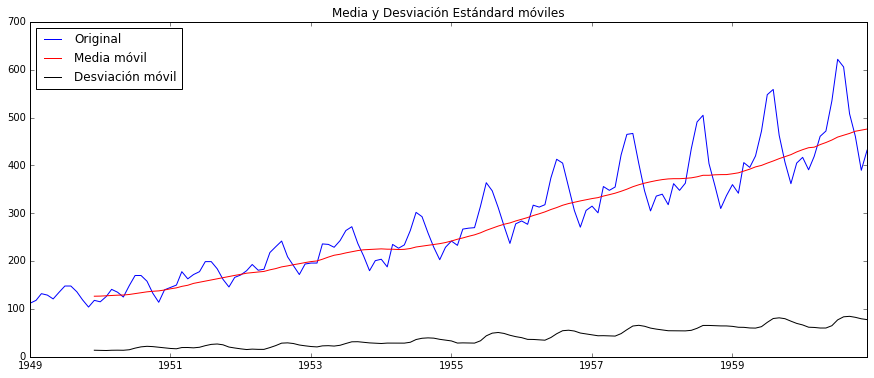

Resultados de la prueba de Dickey-Fuller:
Estadística de la prueba      0.815369
valor-p                       0.991880
#retrasos usados             13.000000
Número de observaciones     130.000000
Valor crítico (1%)           -3.481682
Valor crítico (5%)           -2.884042
Valor crítico (10%)          -2.578770
dtype: float64


In [9]:
# ver si es estacionaria, pues muchos modelos requieren que lo sea
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    # mMedidas móviles
    rol = timeseries.rolling(window=12, center=False)
    rolmean = rol.mean()
    rolstd = rol.std()

    #graficar medidas móviles:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Media móvil')
    std = plt.plot(rolstd, color='black', label = 'Desviación móvil')
    plt.legend(loc='best')
    plt.title('Media y Desviación Estándard móviles')
    plt.show(block=False)
    
    #Realiza prueba de Dickey-Fuller:
    print ('Resultados de la prueba de Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estadística de la prueba','valor-p','#retrasos usados','Número de observaciones'])
    for key,value in dftest[4].items():
        dfoutput['Valor crítico (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

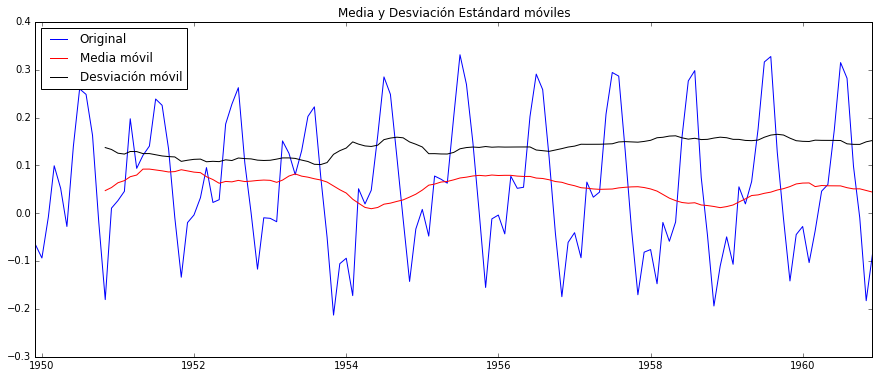

Resultados de la prueba de Dickey-Fuller:
Estadística de la prueba     -3.162908
valor-p                       0.022235
#retrasos usados             13.000000
Número de observaciones     119.000000
Valor crítico (1%)           -3.486535
Valor crítico (5%)           -2.886151
Valor crítico (10%)          -2.579896
dtype: float64


In [74]:
# volviéndola estacionaria  (eliminando la tendencia)
ts_log = np.log(ts)  # transformación, le baja un poco la desv. estándar, penalizando valores altos
rol = ts_log.rolling(window=12, center=False)
rolmean = rol.mean()
diferencia = ts_log - rolmean
diferencia.dropna(inplace=True)  # borra elementos nulos
test_stationarity(diferencia) # la serie diferencia es estacionaria con 95% de confianza

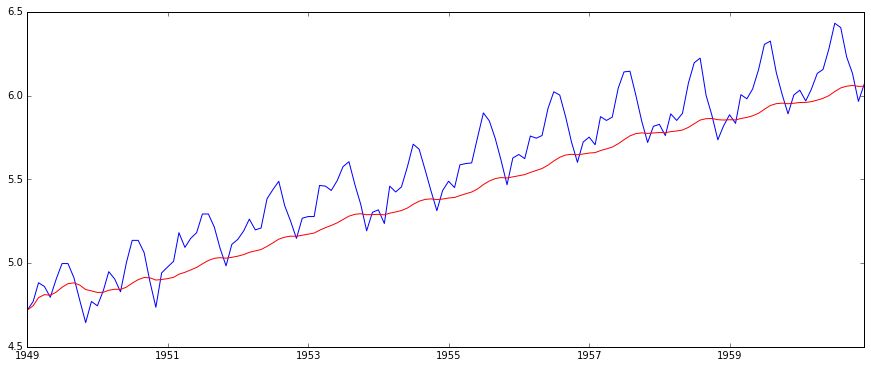

In [11]:
# mejorando estacionariedad con PMPE
promedio_movil_ponderado_exponencial = ts_log.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()
plt.plot(ts_log)
plt.plot(promedio_movil_ponderado_exponencial, color='red')

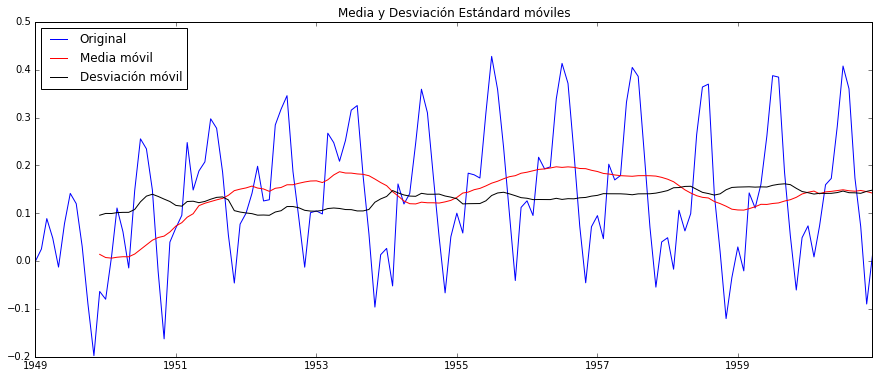

Resultados de la prueba de Dickey-Fuller:
Estadística de la prueba     -3.601262
valor-p                       0.005737
#retrasos usados             13.000000
Número de observaciones     130.000000
Valor crítico (1%)           -3.481682
Valor crítico (5%)           -2.884042
Valor crítico (10%)          -2.578770
dtype: float64


In [76]:
dif_pmpe = ts_log - promedio_movil_ponderado_exponencial
test_stationarity(dif_pmpe) # ahora si estadística menor al v.c. 1%, i.e. 99% de confianza (aunque no siempre funcionan estos métodos)

# Eliminando tendencia y estacionalidad

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01    0.164303
1949-04-01    0.089128
1949-05-01   -0.087011
Name: #Passengers, dtype: float64


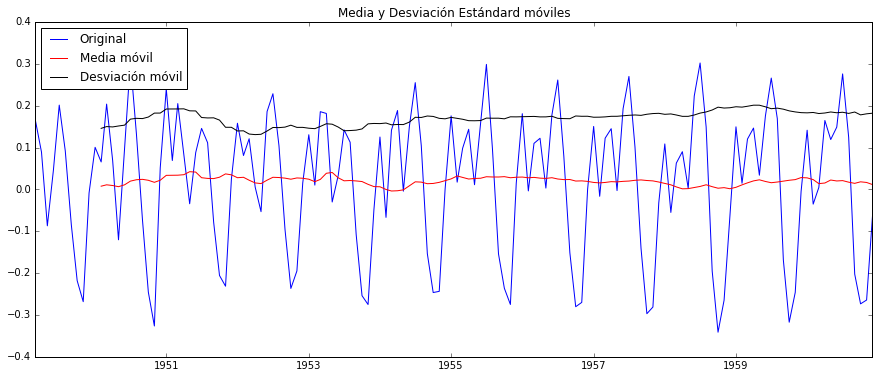

Resultados de la prueba de Dickey-Fuller:
Estadística de la prueba     -3.167907
valor-p                       0.021919
#retrasos usados             11.000000
Número de observaciones     130.000000
Valor crítico (1%)           -3.481682
Valor crítico (5%)           -2.884042
Valor crítico (10%)          -2.578770
dtype: float64


In [81]:
# Eliminando estacionalidad con diferencia (traslape con si misma desplazada en el tiempo)
dif = ts_log - ts_log.shift(2) # desplazada un lugar
print(dif.head())
dif.dropna(inplace=True)
test_stationarity(dif)  # confianza de 90%

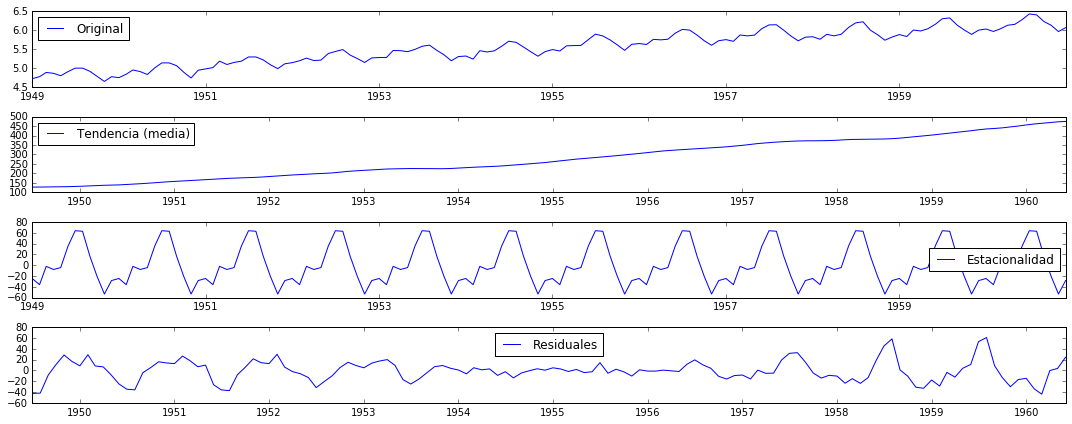

In [82]:
# eliminando tendencia y estacionalidad por descomposición
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Tendencia (media)')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Estacionalidad')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuales')
plt.legend(loc='best')
plt.tight_layout()

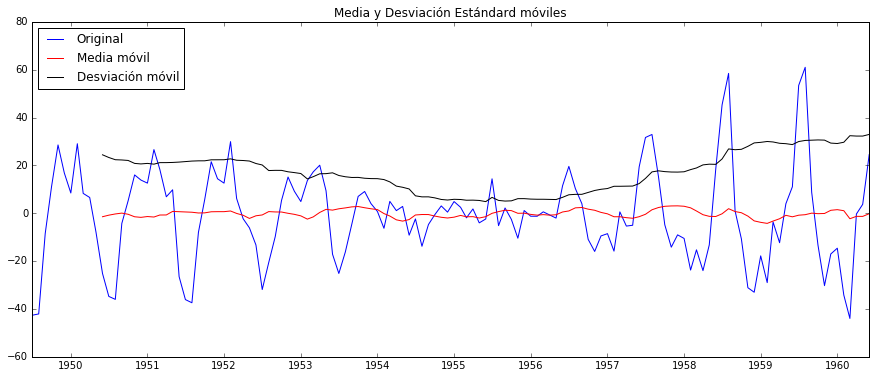

Resultados de la prueba de Dickey-Fuller:
Estadística de la prueba     -5.298428
valor-p                       0.000006
#retrasos usados             13.000000
Número de observaciones     118.000000
Valor crítico (1%)           -3.487022
Valor crítico (5%)           -2.886363
Valor crítico (10%)          -2.580009
dtype: float64


In [83]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)